In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [ ]:
datPath = "/Users/whysocurious/Documents/MLDSAIProjects/BigMartSalesPred_Hackathon/data/raw/"

train = pd.read_csv(datPath+'train_v9rqX0R.csv')
test = pd.read_csv(datPath+'test_AbJTz2l.csv')

print("=== Initial Data Exploration ===")
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print("\nTrain data types:")
print(train.dtypes)

=== Initial Data Exploration ===
Train shape: (8523, 12)
Test shape: (5681, 11)

Train data types:
Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object


In [3]:
# Check for missing values
print("\n=== Missing Values Analysis ===")
missing_train = train.isnull().sum()
missing_test = test.isnull().sum()

print("Missing values in train:")
print(missing_train[missing_train > 0])
print("\nMissing values in test:")
print(missing_test[missing_test > 0])



=== Missing Values Analysis ===
Missing values in train:
Item_Weight    1463
Outlet_Size    2410
dtype: int64

Missing values in test:
Item_Weight     976
Outlet_Size    1606
dtype: int64


In [4]:
# unique values in categorical columns
categorical_cols = [col for col in train.columns if train[col].dtype == 'object' if col not in ['Item_Identifier']] 
#['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

print("\n=== Categorical Variables Overview ===")
for col in categorical_cols:
    if col in train.columns:
        print(f"\n{col}:")
        print(train[col].value_counts())


=== Categorical Variables Overview ===

Item_Fat_Content:
Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

Item_Type:
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64

Outlet_Identifier:
Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: count, dtype: int64

Outlet_Size:
Outlet_Size
Medium    2793
Small     2388
High       932
Name: count, dt

In [5]:
# Check target variable distribution
print("\n=== Target Variable Analysis ===")
print(f"Sales statistics:")
print(train['Item_Outlet_Sales'].describe())


=== Target Variable Analysis ===
Sales statistics:
count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64


In [6]:
# Check for skewness
skewness = train['Item_Outlet_Sales'].skew()
print(f"Sales skewness: {skewness:.3f}")


Sales skewness: 1.178


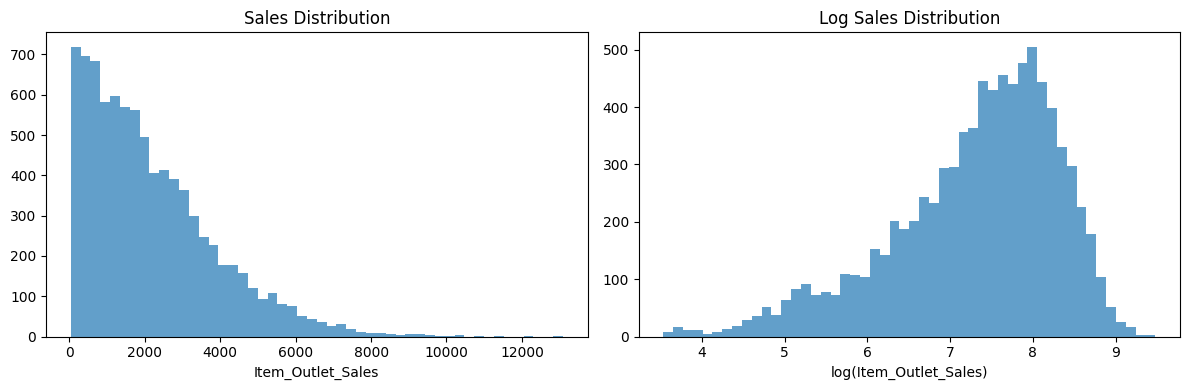

In [7]:
# Plot sales distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(train['Item_Outlet_Sales'], bins=50, alpha=0.7)
plt.title('Sales Distribution')
plt.xlabel('Item_Outlet_Sales')

plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['Item_Outlet_Sales']), bins=50, alpha=0.7)
plt.title('Log Sales Distribution')
plt.xlabel('log(Item_Outlet_Sales)')
plt.tight_layout()
plt.show()

In [8]:
print("Analyzing how Item_MRP varies across Item Types and Outlet Types")

# Basic price statistics
print("\n=== OVERALL PRICE STATISTICS ===")
print(train['Item_MRP'].describe())


# Calculate price statistics by item type
price_by_item_type = train.groupby(["Item_Identifier",])['Item_MRP'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max',
    lambda x: x.quantile(0.25),  # Q1
    lambda x: x.quantile(0.75),  # Q3
    lambda x: x.max() - x.min(),  # Range
    lambda x: x.std() / x.mean() if x.mean() > 0 else 0  # Coefficient of Variation
]).round(2)

price_by_item_type.columns = ['Count', 'Mean', 'Median', 'Std', 'Min', 'Max', 'Q1', 'Q3', 'Range', 'CV']

# Sort by coefficient of variation to see most variable categories
price_by_item_type_sorted = price_by_item_type.sort_values('CV', ascending=False)

print("Price statistics by Item Type (sorted by price variability):")
print(price_by_item_type_sorted)

# Identify most and least variable item types
print(f"\nMOST VARIABLE Item Types (highest CV):")
for i, (item_type, row) in enumerate(price_by_item_type_sorted.head(10).iterrows()):
    print(f"{i+1}. {item_type}: CV={row['CV']:.3f}, Range=₹{row['Range']:.0f} (₹{row['Min']:.0f}-₹{row['Max']:.0f})")

print(f"\nLEAST VARIABLE Item Types (lowest CV):")
for i, (item_type, row) in enumerate(price_by_item_type_sorted.tail(10).iterrows()):
    print(f"{i+1}. {item_type}: CV={row['CV']:.3f}, Range=₹{row['Range']:.0f} (₹{row['Min']:.0f}-₹{row['Max']:.0f})")

price_by_item_type.Range.value_counts()

Analyzing how Item_MRP varies across Item Types and Outlet Types

=== OVERALL PRICE STATISTICS ===
count    8523.000000
mean      140.992782
std        62.275067
min        31.290000
25%        93.826500
50%       143.012800
75%       185.643700
max       266.888400
Name: Item_MRP, dtype: float64
Price statistics by Item Type (sorted by price variability):
                 Count    Mean  Median   Std     Min     Max      Q1      Q3  \
Item_Identifier                                                                
DRM48                4   37.46   37.38  1.72   35.88   39.18   36.03   38.81   
FDX10                4   35.46   35.69  1.93   33.29   37.19   34.11   37.04   
NCE31                8   34.47   34.52  1.38   32.92   36.32   33.20   35.50   
FDG22                4   37.07   37.57  1.42   35.02   38.12   36.67   37.97   
FDL52                7   38.39   37.95  1.38   36.75   39.85   37.30   39.80   
...                ...     ...     ...   ...     ...     ...     ...     ...   
F

Range
3.1    100
3.2     91
3.3     86
3.4     81
3.5     77
2.5     73
3.0     71
2.9     69
3.6     67
2.6     66
3.8     65
2.8     62
2.7     61
3.7     57
2.4     50
2.1     45
3.9     45
2.2     37
2.3     36
1.6     34
1.9     33
2.0     32
1.5     32
1.8     22
4.0     22
1.4     20
1.7     19
1.3     14
1.2     12
1.1     12
1.0     11
0.9     10
0.0      9
0.6      7
0.7      5
0.5      5
0.4      5
0.3      5
0.8      5
0.1      3
0.2      3
Name: count, dtype: int64

In [9]:
print("Analyzing how Item_MRP varies across Item Types and Outlet Types")

# Basic price statistics
print("\n=== OVERALL PRICE STATISTICS ===")
print(train['Item_MRP'].describe())


# Calculate price statistics by item type
price_by_item_type = train.groupby(["Item_Identifier","Item_Type","Outlet_Type"])['Item_MRP'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max',
    lambda x: x.quantile(0.25),  # Q1
    lambda x: x.quantile(0.75),  # Q3
    lambda x: x.max() - x.min(),  # Range
    lambda x: x.std() / x.mean() if x.mean() > 0 else 0  # Coefficient of Variation
]).round(2)

price_by_item_type.columns = ['Count', 'Mean', 'Median', 'Std', 'Min', 'Max', 'Q1', 'Q3', 'Range', 'CV']

# Sort by coefficient of variation to see most variable categories
price_by_item_type_sorted = price_by_item_type.sort_values('CV', ascending=False)

print("Price statistics by Item Type (sorted by price variability):")
print(price_by_item_type_sorted)

# Identify most and least variable item types
print(f"\nMOST VARIABLE Item Types (highest CV):")
for i, (item_type, row) in enumerate(price_by_item_type_sorted.head(10).iterrows()):
    print(f"{i+1}. {item_type}: CV={row['CV']:.3f}, Range=₹{row['Range']:.0f} (₹{row['Min']:.0f}-₹{row['Max']:.0f})")

print(f"\nLEAST VARIABLE Item Types (lowest CV):")
for i, (item_type, row) in enumerate(price_by_item_type_sorted.tail(10).iterrows()):
    print(f"{i+1}. {item_type}: CV={row['CV']:.3f}, Range=₹{row['Range']:.0f} (₹{row['Min']:.0f}-₹{row['Max']:.0f})")

price_by_item_type.Range.value_counts()

Analyzing how Item_MRP varies across Item Types and Outlet Types

=== OVERALL PRICE STATISTICS ===
count    8523.000000
mean      140.992782
std        62.275067
min        31.290000
25%        93.826500
50%       143.012800
75%       185.643700
max       266.888400
Name: Item_MRP, dtype: float64
Price statistics by Item Type (sorted by price variability):
                                                      Count    Mean  Median  \
Item_Identifier Item_Type          Outlet_Type                                
DRH15           Dairy              Supermarket Type1      2   43.94   43.94   
FDY35           Breads             Grocery Store          2   45.94   45.94   
DRK35           Hard Drinks        Grocery Store          2   37.75   37.75   
FDX10           Snack Foods        Supermarket Type1      3   34.95   34.39   
NCO06           Household          Supermarket Type1      3   33.79   33.36   
...                                                     ...     ...     ...   
NCZ53    

Range
0.0    2648
2.5      80
2.4      66
2.1      63
3.2      62
2.6      61
3.3      61
2.7      58
2.8      57
1.5      55
2.2      55
2.9      54
3.0      54
2.3      53
2.0      52
1.6      50
3.1      50
1.0      49
1.8      48
3.5      45
1.9      43
1.7      42
3.4      42
1.2      41
3.8      36
1.4      35
1.3      34
3.6      34
0.8      33
3.7      30
0.2      26
0.9      26
0.6      23
0.7      23
3.9      22
0.5      21
1.1      21
0.1      20
0.4      19
0.3      16
4.0       6
Name: count, dtype: int64

In [10]:
train = train.merge(train.pivot_table(index=["Item_Identifier","Item_Type","Outlet_Type"],
                                        values="Item_MRP", 
                                        aggfunc=np.nanmedian).sort_values(by="Item_Identifier", 
                                                                            ascending=False).reset_index().rename(columns={"Item_MRP":"Median_Item_MRP"}), 
                                                                            on=["Item_Identifier","Item_Type","Outlet_Type"], how="left")
train = train.merge(train.pivot_table(index=["Item_Type","Outlet_Type"],
                                        values="Item_MRP", 
                                        aggfunc=np.nanmedian).sort_values(by="Item_Type", 
                                                                            ascending=False).reset_index().rename(columns={"Item_MRP":"Median_Item_MRP_1"}), 
                                                                            on=["Item_Type","Outlet_Type"], how="left")
print (train.shape)

(8523, 14)


In [11]:
print(train['Item_Weight'].describe())

# Calculate price statistics by item type
price_by_item_type = train.groupby(["Item_Identifier","Item_Type","Outlet_Type","Median_Item_MRP"])['Item_Weight'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max',
    lambda x: x.quantile(0.25),  # Q1
    lambda x: x.quantile(0.75),  # Q3
    lambda x: x.max() - x.min(),  # Range
    lambda x: x.std() / x.mean() if x.mean() > 0 else 0  # Coefficient of Variation
]).round(2)

price_by_item_type.columns = ['Count', 'Mean', 'Median', 'Std', 'Min', 'Max', 'Q1', 'Q3', 'Range', 'CV']

# Sort by coefficient of variation to see most variable categories
price_by_item_type_sorted = price_by_item_type.sort_values('CV', ascending=False)

print("Price statistics by Item Type (sorted by price variability):")
print(price_by_item_type_sorted)

# Identify most and least variable item types
print(f"\nMOST VARIABLE Item Types (highest CV):")
for i, (item_type, row) in enumerate(price_by_item_type_sorted.head(10).iterrows()):
    print(f"{i+1}. {item_type}: CV={row['CV']:.3f}, Range=₹{row['Range']:.0f} (₹{row['Min']:.0f}-₹{row['Max']:.0f})")

print(f"\nLEAST VARIABLE Item Types (lowest CV):")
for i, (item_type, row) in enumerate(price_by_item_type_sorted.tail(10).iterrows()):
    print(f"{i+1}. {item_type}: CV={row['CV']:.3f}, Range=₹{row['Range']:.0f} (₹{row['Min']:.0f}-₹{row['Max']:.0f})")

price_by_item_type.Range.value_counts()

count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64
Price statistics by Item Type (sorted by price variability):
                                                                      Count  \
Item_Identifier Item_Type          Outlet_Type       Median_Item_MRP          
DRA12           Soft Drinks        Supermarket Type1 141.7654             4   
FDV35           Breads             Supermarket Type1 156.1314             3   
FDV27           Meat               Supermarket Type1 88.9014              2   
FDV28           Frozen Foods       Supermarket Type1 33.6058              4   
                                   Supermarket Type3 34.9558              0   
...                                                                     ...   
NCZ42           Household          Grocery Store     238.3248             1   
NCZ53           Health and

Range
0.0    3033
Name: count, dtype: int64

## No variation in Item_Weight across Item Types and Outlet Types and Median Price

In [12]:

train = train.merge(train.pivot_table(index=["Item_Identifier","Outlet_Type","Median_Item_MRP"],
                                      values="Item_Weight",
                                        aggfunc=np.nanmean).sort_values(by="Item_Identifier",
                                                                         ascending=False).reset_index().rename(columns={"Item_Weight":"Mean_Item_Weight_1"}), 
                                                                         how="left",
                                                                         on=["Item_Identifier","Outlet_Type","Median_Item_MRP"])
train = train.merge(train.pivot_table(index=["Item_Identifier","Item_MRP"],
                                      values="Item_Weight",
                                        aggfunc=np.nanmean).sort_values(by="Item_Identifier",
                                                                         ascending=False).reset_index().rename(columns={"Item_Weight":"Mean_Item_Weight_2"}), 
                                                                         how="left",
                                                                         on=["Item_Identifier","Item_MRP"])
train = train.merge(train.pivot_table(index=["Item_Identifier"],
                                      values="Item_Weight",
                                        aggfunc=np.nanmean).sort_values(by="Item_Identifier",
                                                                         ascending=False).reset_index().rename(columns={"Item_Weight":"Mean_Item_Weight_3"}), 
                                                                         how="left",
                                                                         on=["Item_Identifier"])
train = train.merge(train.pivot_table(index=["Item_Type","Median_Item_MRP_1"],
                                      values="Item_Weight",
                                        aggfunc=np.nanmean).sort_values(by="Item_Type",
                                                                         ascending=False).reset_index().rename(columns={"Item_Weight":"Mean_Item_Weight_4"}), 
                                                                         how="left",
                                                                         on=["Item_Type","Median_Item_MRP_1"])
                                                                         

print (train.shape)


(8523, 18)


In [13]:
print (train['Item_Weight'].describe())
train.loc[train.Item_Weight.isnull(), 'Item_Weight'] = train.loc[train.Item_Weight.isnull(), 'Mean_Item_Weight_1']
train.loc[train.Item_Weight.isnull(), 'Item_Weight'] = train.loc[train.Item_Weight.isnull(), 'Mean_Item_Weight_2']
train.loc[train.Item_Weight.isnull(), 'Item_Weight'] = train.loc[train.Item_Weight.isnull(), 'Mean_Item_Weight_3']
train.loc[train.Item_Weight.isnull(), 'Item_Weight'] = train.loc[train.Item_Weight.isnull(), 'Mean_Item_Weight_4']

train["perUnitCost"] = train["Item_Weight"] / train["Item_MRP"]
train = train.merge(train.pivot_table(index=["Item_Type","Outlet_Type"],
                                      values=["perUnitCost"],
                                      aggfunc=np.nanmean).rename(columns={"perUnitCost":"Mean_perUnitCost"}),
                                       how="left",
                                       on=["Item_Type","Outlet_Type"])
train["Item_Weigh_5"] = train["Item_MRP"] * train["Mean_perUnitCost"]
train.loc[train.Item_Weight.isnull(), 'Item_Weight'] = train.loc[train.Item_Weight.isnull(), 'Item_Weigh_5']
train.drop(columns=['Mean_Item_Weight_1', 'Mean_Item_Weight_2', 'Mean_Item_Weight_3', 'Mean_Item_Weight_4', 'Mean_perUnitCost', 'Item_Weigh_5','Median_Item_MRP','Median_Item_MRP_1',], inplace=True)
print (train['Item_Weight'].describe())

count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64
count    8523.000000
mean       12.874956
std         4.645146
min         4.555000
25%         8.785000
50%        12.650000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64


In [14]:
# Check for missing values
print("\n=== Missing Values Analysis ===")
missing_train = train.isnull().sum()
missing_test = test.isnull().sum()

print("Missing values in train:")
print(missing_train[missing_train > 0])
print("\nMissing values in test:")
print(missing_test[missing_test > 0])




=== Missing Values Analysis ===
Missing values in train:
Outlet_Size    2410
perUnitCost       3
dtype: int64

Missing values in test:
Item_Weight     976
Outlet_Size    1606
dtype: int64


In [365]:
pd.crosstab(train.Outlet_Identifier, train.Outlet_Type)

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Identifier,,,,
OUT010,555,0,0,0
OUT013,0,932,0,0
OUT017,0,926,0,0
OUT018,0,0,928,0
OUT019,528,0,0,0
OUT027,0,0,0,935
OUT035,0,930,0,0
OUT045,0,929,0,0
OUT046,0,930,0,0


In [366]:
np.sum(pd.crosstab(train.Item_Identifier, train.Item_Type) > 0, axis=1).describe()

count    1559.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64

In [367]:
print(f"Item_Weight nulls after imputation: {train['Item_Weight'].isnull().sum()}")


Item_Weight nulls after imputation: 0


In [368]:

# 2. Handle Outlet_Size missing values
print("\n2. Handling Outlet_Size missing values...")
print(f"Missing Outlet_Size: {train['Outlet_Size'].isnull().sum()}")

# Create contingency table to understand patterns
print("\nOutlet_Size vs Outlet_Type:")
size_type_crosstab = pd.crosstab(train['Outlet_Size'], train['Outlet_Type'], margins=True)
size_type_crosstab




2. Handling Outlet_Size missing values...
Missing Outlet_Size: 2410

Outlet_Size vs Outlet_Type:


Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3,All
Outlet_Size,,,,,
High,0,932,0,0,932
Medium,0,930,928,935,2793
Small,528,1860,0,0,2388
All,528,3722,928,935,6113


In [ ]:
# train.Outlet_Size.fillna("Missing", inplace=True)

In [348]:
train.pivot_table(index=['Outlet_Identifier'], columns="Outlet_Size", values="Item_Outlet_Sales", aggfunc='mean')

Outlet_Size,High,Medium,Missing,Small
Outlet_Identifier,,,,
OUT010,NaN,NaN,339.351662,NaN
OUT013,2298.995256,NaN,NaN,NaN
OUT017,NaN,NaN,2340.675263,NaN
OUT018,NaN,1995.498739,NaN,NaN
OUT019,NaN,NaN,NaN,340.329723
OUT027,NaN,3694.038558,NaN,NaN
OUT035,NaN,NaN,NaN,2438.841866
OUT045,NaN,NaN,2192.384798,NaN
OUT046,NaN,NaN,NaN,2277.844267


In [347]:
train.pivot_table(index=['Outlet_Establishment_Year', 'Outlet_Location_Type','Outlet_Type',], columns="Outlet_Size", values="Item_Outlet_Sales", aggfunc='mean')

Outlet_Size                                                              High  \
Outlet_Establishment_Year Outlet_Location_Type Outlet_Type                      
1985                      Tier 1               Grocery Store              NaN   
                          Tier 3               Supermarket Type3          NaN   
1987                      Tier 3               Supermarket Type1  2298.995256   
1997                      Tier 1               Supermarket Type1          NaN   
1998                      Tier 3               Grocery Store              NaN   
1999                      Tier 1               Supermarket Type1          NaN   
2002                      Tier 2               Supermarket Type1          NaN   
2004                      Tier 2               Supermarket Type1          NaN   
2007                      Tier 2               Supermarket Type1          NaN   
2009                      Tier 3               Supermarket Type2          NaN   

Outlet_Size                                                            Medium  \
Outlet_Establishment_Year Outlet_Location_Type Outlet_Type                      
1985                      Tier 1               Grocery Store              NaN   
                          Tier 3               Supermarket Type3  3694.038558   
1987                      Tier 3               Supermarket Type1          NaN   
1997                      Tier 1               Supermarket Type1          NaN   
1998                      Tier 3               Grocery Store              NaN   
1999                      Tier 1               Supermarket Type1  2348.354635   
2002                      Tier 2               Supermarket Type1          NaN   
2004                      Tier 2               Supermarket Type1          NaN   
2007                      Tier 2               Supermarket Type1          NaN   
2009                      Tier 3               Supermarket Type2  1995.498739   

Outlet_Size                                                           Missing  \
Outlet_Establishment_Year Outlet_Location_Type Outlet_Type                      
1985                      Tier 1               Grocery Store              NaN   
                          Tier 3               Supermarket Type3          NaN   
1987                      Tier 3               Supermarket Type1          NaN   
1997                      Tier 1               Supermarket Type1          NaN   
1998                      Tier 3               Grocery Store       339.351662   
1999                      Tier 1               Supermarket Type1          NaN   
2002                      Tier 2               Supermarket Type1  2192.384798   
2004                      Tier 2               Supermarket Type1          NaN   
2007                      Tier 2               Supermarket Type1  2340.675263   
2009                      Tier 3               Supermarket Type2          NaN   

Outlet_Size                                                             Small  
Outlet_Establishment_Year Outlet_Location_Type Outlet_Type                     
1985                      Tier 1               Grocery Store       340.329723  
                          Tier 3               Supermarket Type3          NaN  
1987                      Tier 3               Supermarket Type1          NaN  
1997                      Tier 1               Supermarket Type1  2277.844267  
1998                      Tier 3               Grocery Store              NaN  
1999                      Tier 1               Supermarket Type1          NaN  
2002                      Tier 2               Supermarket Type1          NaN  
2004                      Tier 2               Supermarket Type1  2438.841866  
2007                      Tier 2               Supermarket Type1          NaN  
2009                      Tier 3               Supermarket Type2          NaN

In [383]:
outlet_size_mode = train.groupby(['Outlet_Location_Type','Outlet_Type',])['Outlet_Size'].apply(
    lambda x: x.mode()[0] if not x.mode().empty else 'Small'
)
print (outlet_size_mode)

train['Outlet_Size'] = train.apply(
    lambda row: outlet_size_mode[row['Outlet_Location_Type'],row['Outlet_Type']] 
    if pd.isna(row['Outlet_Size']) else row['Outlet_Size'], 
    axis=1
)

print(f"Outlet_Size nulls after imputation: {train['Outlet_Size'].isnull().sum()}")

Outlet_Location_Type  Outlet_Type      
Tier 1                Grocery Store         Small
                      Supermarket Type1    Medium
Tier 2                Supermarket Type1     Small
Tier 3                Grocery Store         Small
                      Supermarket Type1      High
                      Supermarket Type2    Medium
                      Supermarket Type3    Medium
Name: Outlet_Size, dtype: object
Outlet_Size nulls after imputation: 0


In [384]:
train.pivot_table(index=['Outlet_Establishment_Year', 'Outlet_Location_Type','Outlet_Type',], columns="Outlet_Size", values="Item_Outlet_Sales", aggfunc='mean')

Outlet_Size                                                              High  \
Outlet_Establishment_Year Outlet_Location_Type Outlet_Type                      
1985                      Tier 1               Grocery Store              NaN   
                          Tier 3               Supermarket Type3          NaN   
1987                      Tier 3               Supermarket Type1  2298.995256   
1997                      Tier 1               Supermarket Type1          NaN   
1998                      Tier 3               Grocery Store              NaN   
1999                      Tier 1               Supermarket Type1          NaN   
2002                      Tier 2               Supermarket Type1          NaN   
2004                      Tier 2               Supermarket Type1          NaN   
2007                      Tier 2               Supermarket Type1          NaN   
2009                      Tier 3               Supermarket Type2          NaN   

Outlet_Size                                                            Medium  \
Outlet_Establishment_Year Outlet_Location_Type Outlet_Type                      
1985                      Tier 1               Grocery Store              NaN   
                          Tier 3               Supermarket Type3  3694.038558   
1987                      Tier 3               Supermarket Type1          NaN   
1997                      Tier 1               Supermarket Type1          NaN   
1998                      Tier 3               Grocery Store              NaN   
1999                      Tier 1               Supermarket Type1  2348.354635   
2002                      Tier 2               Supermarket Type1          NaN   
2004                      Tier 2               Supermarket Type1          NaN   
2007                      Tier 2               Supermarket Type1          NaN   
2009                      Tier 3               Supermarket Type2  1995.498739   

Outlet_Size                                                             Small  
Outlet_Establishment_Year Outlet_Location_Type Outlet_Type                     
1985                      Tier 1               Grocery Store       340.329723  
                          Tier 3               Supermarket Type3          NaN  
1987                      Tier 3               Supermarket Type1          NaN  
1997                      Tier 1               Supermarket Type1  2277.844267  
1998                      Tier 3               Grocery Store       339.351662  
1999                      Tier 1               Supermarket Type1          NaN  
2002                      Tier 2               Supermarket Type1  2192.384798  
2004                      Tier 2               Supermarket Type1  2438.841866  
2007                      Tier 2               Supermarket Type1  2340.675263  
2009                      Tier 3               Supermarket Type2          NaN